In [ ]:
import pathlib
import os
if 'TSL_SCHOOL_DIR' in os.environ:
    if any( (p/".git").is_dir() for p in (pathlib.Path(".").absolute().resolve()/"dummy").parents ):
        raise RuntimeError('Please copy notebook to a work directory')

# Geometry definition in OpenMC

We start by importing the `openmc` module, which contains the API to generate the input files for OpenMC.

In [1]:
import openmc
openmc.config['cross_sections'] = '/home/student/tsl_software/endfb-viii.0-hdf5/cross_sections.xml'

Surface definition is done by instantiating objects. E.g., to create a plane perpendicular to the x axis we do:

In [2]:
plane = openmc.XPlane()

In [3]:
print(type(plane))

<class 'openmc.surface.XPlane'>


An object of the `XPlane` class posses certain attributes and methods that allow to modify it. For instance, by default the plane cuts the $x$ axis in the origin. To change that point we do:

In [4]:
plane.x0 = 10.0

We can also change other properties:

In [5]:
plane.name = "Plane 1"

We can also set these parameters when we call the constructor `XPlane()`:

In [6]:
plane2 = openmc.XPlane(x0=10.0, name="Plane 2")

A plane perpendicular to the $x$ axis is defined by the equation $x-x_0=0$, hence it is only necessary to define one parameter ($x_0$) to define the plane. In a similar fashion, we can define planes perpendicular to the $y$ and $z$ axes:

In [7]:
plane3 = openmc.YPlane(y0=5)
plane4 = openmc.ZPlane(z0=3)

To define a sphere we need to indicate the position $x_0, y_0, z_0$ of the center and its radius, since it is defined by the equation $(x-x_0)^2+(y-y_0)^2+(z-z_0)^2-R^2=0$:

In [8]:
sph = openmc.Sphere(x0=10, r=100)

(the $y_0$ and $z_0$ parameters were not specified and take the default value, 0)

We can also define cylinders parallel to the $x$, $y$, $z$ axes using respectively the classes `XCylinder()`, `YCylinder()` and `ZCylinder()`:

In [9]:
# A cylinder parallel to the x axis with a radius of 10 cm, crossing the point y=2 cm, z=1 cm
cyl1 = openmc.XCylinder(y0=2, z0=1, r=10) 

# A cylinder centered in the y axis with a radius of 5 cm
cyl2 = openmc.YCylinder(r=5) 

# A cylinder centered in the z axis with a radius of 1 cm
cyl3 = openmc.ZCylinder() 

We also have the following classes:
* `Plane()`: defining an arbitrary plane.
* `XCone()`: defining a cone parallel to the $x$ axis.
* `YCone()`: defining a cone parallel to the $y$ axis.
* `ZCone()`: defining a cone parallel to the $z$ axis.
* `Quadric()`: defining a generic quadric surface corresponding to the equation $Ax^2+By^2+Cz^2+Dxy+Eyz+Fxz+Gx+Hy+Jz+K=0$


Each surface we create has an id assigned. If we do not do it explicitly, the numbers are given sequentially:

In [10]:
print(plane.id)
print(cyl3.id)

1
8


These id seem at first redundant because the surfaces are also identified by their name. But, internally OpenMC uses these ids to identify the surface. Also, since other Monte Carlo codes use numbers to identify the surfaces it is sometimes useful to specify them to simplify the comparison between Monte Carlo codes. If we try to create a new surface with an existing id, OpenMC will give us a warning:

In [11]:
new_plane = openmc.XPlane(x0=10, surface_id=999, name="New Plane")
another_plane = openmc.XPlane(x0=1, surface_id=999, name="Another Plane")
print(new_plane.id)
print(another_plane.id)

999
999


/home/nacho/anaconda3/envs/openmc_ncrystal_develop/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another Surface instance already exists with id=999.
  warn(msg, IDWarning)


## Regions

Once we have surfaces, we can use the operators `+` and `-` to define halfspaces:

In [12]:
front = +plane2
back = -plane2
print(type(front))

<class 'openmc.surface.Halfspace'>


These halfspaces can be combined to form regions using the operators `&` (intersection), `|` (union) y `~` (complement). E.g., if we want to define the region inside of a sphere and above its middle plane:

In [13]:
# Surface definition:
sphere = openmc.Sphere(r=10)
middle_plane = openmc.ZPlane(z0=0)

# Define halfspaces based on the surfaces
inside_the_sphere = -sphere
above_middle_plabe = +middle_plane

# And we can now combine these halfspaces to create new regions
north_hemisphere = inside_the_sphere & above_middle_plabe
print(type(north_hemisphere))

<class 'openmc.region.Intersection'>


The region inside the sphere, but below the middle plane can be defined as:

In [14]:
south_hemisphere = inside_the_sphere  & ~north_hemisphere

To construct these regions we can use the De Morgan's laws:
* `~(A | B) = ~A & ~B`
* `~(A & B) = ~A | ~B`

## Cells

Once we have the region, we can define a cell using the `Cell()` class:

In [15]:
umet = openmc.Material()
umet.add_nuclide("U235", 1.0, "ao")
umet.set_density("g/cm3", 19.0)
reactor_core = openmc.Cell(fill=umet, region=south_hemisphere)

where the `fill=` paramater indicates the material that will be used to fill the cell. `None` can be used to make void cells.

In this example the `fill=` parameter uses a material, but cells can also be filled with others cells, in patterns called _universes_.

## Boundary conditions

In other Monte Carlo codes such as MCNP or PHITS the boundary condition is defined in volume by designating a region that will act as black absorber of particles. In OpenMC the boundary conditions are defined in the surface definition with the parameter `boundary_type=`. The default value for this parameter is `transmission`, that lets the particles go through. If instead we use the parameter `vacuum`, OpenMC will kill all the particles that reach the surface, generating a boundary condition of zero incoming current (i.e. vacuum). If we use the parameter  `reflective` the surface will reflect all the particles that reach the surface, creating a reflective boundary condition.

One way to limit the simulation is to set an outer surface (for example a big sphere) with vacuum boundary condition, enclosing the whole simulation:

In [16]:
sph00 = openmc.Sphere(r=100, boundary_type='vacuum')

Two important caveats:

- It is important to note that _vacuum_ boundary conditions and _void_ cells are different things.
- As these boundary conditions can be applied to any surface, including interior surfaces, we must be careful to set boundary conditions with physical sense.

## Universes

In OpenMC we call *universe* to a collection of cells. At least we need to have one universe in our simulation, called `root universe`. Inside the cells of this universe could be other universes, which allows us to generate repeated geometries. In the following example we will define a cube inside a sphere, and with this three cells: 

1) the region inside of the cube, 

2) the region outside the cube and inside the sphere, and

3) the outside of the sphere.

The inside of the cube will be filled with polyethylene and the sphere will be filled with water. Outside of the sphere there is going to be void.

In [17]:
water = openmc.Material()
water.add_nuclide("H1", 2.0, 'ao')
water.add_nuclide("O16", 1.0, 'ao')
water.set_density('g/cm3', 1.0)

ple = openmc.Material()
ple.add_nuclide("H1", 2.0, 'ao')
ple.add_nuclide("C12", 1.0, 'ao')
ple.set_density('g/cm3', 0.9)

sup_plane1 = openmc.XPlane(x0=-7.5)
sup_plane2 = openmc.XPlane(x0=+7.5)
sup_plane3 = openmc.YPlane(y0=-7.5)
sup_plane4 = openmc.YPlane(y0=+7.5)
sup_plane5 = openmc.ZPlane(z0=-7.5)
sup_plane6 = openmc.ZPlane(z0=+7.5)

sup_sphere = openmc.Sphere(r=15, boundary_type='vacuum')
inside_cube = (+sup_plane1 & -sup_plane2) & \
               (+sup_plane3 & -sup_plane4) & \
               (+sup_plane5 & -sup_plane6) 
outside_cube = ~inside_cube
adentro_sphere = -sup_sphere
outside_sphere = +sup_sphere

cel_cube = openmc.Cell(region=inside_cube, fill=ple)
cel_sphere = openmc.Cell(region=adentro_sphere & outside_cube, fill=water)
cel_outside = openmc.Cell(region=outside_sphere & outside_cube, fill=None)

universe = openmc.Universe(cells= [cel_cube, cel_sphere, cel_outside])

Universes can be plotted with the `.plot()` method:

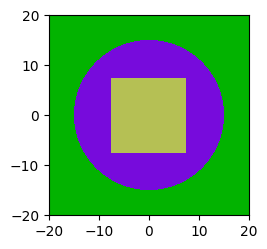

In [18]:
universe.plot(width=(40,40))

Here the `width=` parameter takes a tuple that represents the dimensions of the region to plot in cm.

## Geometry generation

The combination of surfaces, cells and universes that make up the geometry of the simulation need to be combined into a `Geometry()` object. The main parameter of the constructor is the root universe, which contains all the cells and other universes.

In [19]:
geo = openmc.Geometry(root=universe)

This object has a `.export_to_xml()` method to produce the file `geometry.xml` that will be used as input for the simulation. 

In [20]:
geo.export_to_xml()

In [21]:
!cat geometry.xml

<?xml version='1.0' encoding='utf-8'?>
<geometry>
  <cell id="2" material="3" region="12 -13 14 -15 16 -17" universe="1" />
  <cell id="3" material="2" region="-18 ~(12 -13 14 -15 16 -17)" universe="1" />
  <cell id="4" material="void" region="18 ~(12 -13 14 -15 16 -17)" universe="1" />
  <surface coeffs="-7.5" id="12" type="x-plane" />
  <surface coeffs="7.5" id="13" type="x-plane" />
  <surface coeffs="-7.5" id="14" type="y-plane" />
  <surface coeffs="7.5" id="15" type="y-plane" />
  <surface coeffs="-7.5" id="16" type="z-plane" />
  <surface coeffs="7.5" id="17" type="z-plane" />
  <surface coeffs="0.0 0.0 0.0 15" id="18" type="sphere" />
</geometry>
